<a href="https://colab.research.google.com/github/siontama/Data-Science/blob/master/vgg_flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필요한 라이브러리 import 시키기**


In [1]:
from google.colab import drive

import tensorflow as tf # 일단은 import 시켜두자.

import numpy as np
import pandas as pd

import cv2
import scipy
from skimage import io

from PIL import ImageFile
from tqdm import tqdm

drive.mount('/content/gdrive')

tf.set_random_seed(777)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [3]:
from keras.preprocessing import image as keras_image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.481528992000023
GPU (s):
2.100824079000006
GPU speedup over CPU: 4x


# 여러가지 함수 정의하기

In [0]:
# 손실 계산하는 함수
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  

# 정확도 측정하는 함수
def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy');
    
# 이미지 tensor로 바꿔주는 함수
# keras.processing의 내장 함수인 img_to_array() 함수를 이용하여 이미지들을 Tensor로 변환한다.
def path_to_tensor(img_path):
    # 자신의 드라이브에 맞는 경로를 넣는다.
    img = keras_image.load_img("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/"+img_path, 
                               target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

# 이미지 여러개 tensor들로 바꿔주는 함수
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data 시각화를 통해 조사해보기

In [0]:
flowers = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/flower_labels.csv") # 자신의 drive에 있는 데이터셋 경로(엑셀 파일)
flower_files = flowers['file']
flower_targets = flowers['label'].values

Label:  2


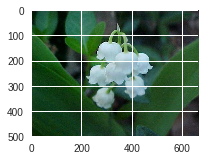

In [10]:
# 168번째 데이터가 어떤 것인지 확인해보자.

print('Label: ', flower_targets[168])
flower_image = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/"+flower_files[168])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

# Data를 Tensor로 변환

keras.processing의 내장 함수인 img_to_array() 함수를 이용하여 이미지들을 Tensor로 변환한다.

In [11]:
flower_tensors = paths_to_tensor(flower_files)

100%|██████████| 1360/1360 [07:00<00:00,  3.22it/s]


# 훈련 셋과 테스트 셋으로 나누기

In [12]:
# 전체 데이터 셋의 80퍼센트는 훈련 셋으로 나머지 20퍼센트는 테스트 셋으로 나누었다.
# 또한, 무작위로 훈련 셋과 테스트 셋을 뽑는 것이 학습에 도움이 되기에 무작위로 뽑았다.
x_train, x_test, y_train, y_test = train_test_split(flower_tensors, flower_targets, 
                                                    test_size = 0.2, random_state = 1)
print([x_train.shape, y_train.shape, x_test.shape, y_test.shape])

[(1088, 128, 128, 3), (1088,), (272, 128, 128, 3), (272,)]


# 테스트 셋에서 검증 셋으로 나누기

테스트 셋의 절반을 검증 셋으로 다시 나누어 주었다.

In [13]:
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]
print(x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape)

(1088, 128, 128, 3) (136, 128, 128, 3) (136, 128, 128, 3) (1088,) (136,) (136,)


Label:  0


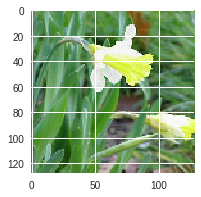

In [14]:
# 훈련 셋의 1번 데이터가 무엇인지 살펴보자.

print('Label: ', y_train[1])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]/255).reshape(128,128,3));

# 데이터 처리하기

In [15]:
# 데이터 형태 지정하기
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_valid = x_valid.astype('float32')/255

# 클래스 벡터(정수들)를 바이너리 클래스 매트릭스로 변환한다고 함.
c_y_train = to_categorical(y_train, 17)
c_y_test = to_categorical(y_test, 17)
c_y_valid = to_categorical(y_valid, 17)

print([x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape, x_valid.shape, c_y_valid.shape])

[(1088, 128, 128, 3), (1088, 17), (136, 128, 128, 3), (136, 17), (136, 128, 128, 3), (136, 17)]


# 모델 만들기 : CNN

mlp 모델로 학습시켰을 때는 정확도가 낮게 나왔다.
따라서, mlp 모델 보다 나은 모델인 CNN을 만들어 학습시켜보자.

In [0]:
from keras.regularizers import l2

# 함수로 CNN을 정의하자.

# CNN
def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=x_train.shape[1:], padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

# CNN으로 만든 모델에 학습 시키기

In [37]:
# CNN에 학습시키기

cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=50, batch_size=128, verbose=2,
                                  validation_data=(x_valid, c_y_valid))

Train on 1088 samples, validate on 136 samples
Epoch 1/50
 - 8s - loss: 3.4187 - acc: 0.0478 - val_loss: 3.3262 - val_acc: 0.0515
Epoch 2/50
 - 6s - loss: 3.2678 - acc: 0.0653 - val_loss: 3.1932 - val_acc: 0.0515
Epoch 3/50
 - 6s - loss: 3.1458 - acc: 0.0699 - val_loss: 3.0936 - val_acc: 0.0956
Epoch 4/50
 - 6s - loss: 3.0611 - acc: 0.0919 - val_loss: 3.0290 - val_acc: 0.0515
Epoch 5/50
 - 6s - loss: 3.0035 - acc: 0.0671 - val_loss: 2.9737 - val_acc: 0.0956
Epoch 6/50
 - 6s - loss: 2.9529 - acc: 0.0754 - val_loss: 2.9123 - val_acc: 0.0956
Epoch 7/50
 - 6s - loss: 2.8371 - acc: 0.1094 - val_loss: 2.7004 - val_acc: 0.1471
Epoch 8/50
 - 6s - loss: 2.7259 - acc: 0.1176 - val_loss: 2.6078 - val_acc: 0.2206
Epoch 9/50
 - 6s - loss: 2.6502 - acc: 0.1654 - val_loss: 2.5276 - val_acc: 0.2206
Epoch 10/50
 - 6s - loss: 2.5577 - acc: 0.1847 - val_loss: 2.3093 - val_acc: 0.2794
Epoch 11/50
 - 6s - loss: 2.4931 - acc: 0.2068 - val_loss: 2.3365 - val_acc: 0.2353
Epoch 12/50
 - 6s - loss: 2.3328 - acc

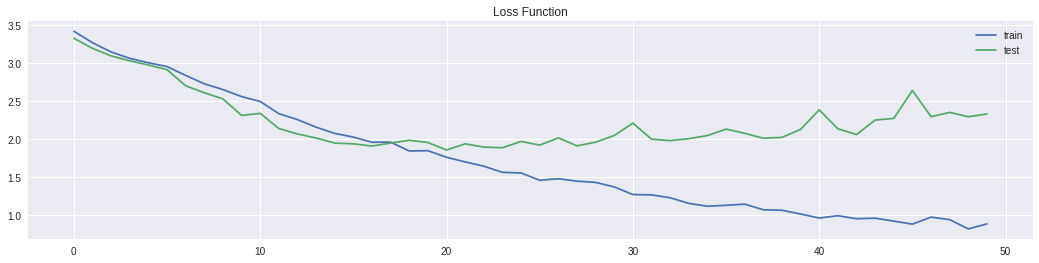

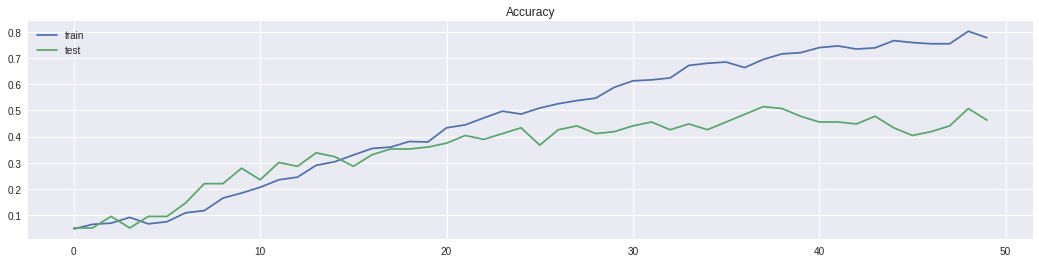

In [38]:
# 손실과 정확도를 마찬가지로 따져보자.

loss_plot(cnn_mc_history)
acc_plot(cnn_mc_history)

# Test 셋을 이용한 모델 정확도 평가

In [39]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
print(cnn_mc_test_score)

136/136 [==============================] - 0s 3ms/step
[1.9998480852912455, 0.5147058823529411]


In [40]:
# 이건 뭐지??? => 약간 매개변수 조정하고 한듯..(최적화 단계?)

data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
cnn_mc_dg_history = cnn_mc_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch=189, epochs=3, verbose=2, 
                                               validation_data=(x_valid, c_y_valid))

Epoch 1/3
 - 69s - loss: 1.8105 - acc: 0.4809 - val_loss: 1.5708 - val_acc: 0.5074
Epoch 2/3
 - 69s - loss: 1.5474 - acc: 0.5683 - val_loss: 1.4809 - val_acc: 0.5956
Epoch 3/3
 - 66s - loss: 1.4018 - acc: 0.6178 - val_loss: 1.4289 - val_acc: 0.5956


In [41]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
print(cnn_mc_test_score)

136/136 [==============================] - 0s 3ms/step
[1.2846187493380379, 0.6838235294117647]
